## HotDog or No Hotdog!
Training on local storage

In [80]:
import mltoolbox.image.classification as model
from google.datalab.ml import *
import google.datalab.bigquery as bq
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import time

In [100]:
worker_dir = '/content/hotdog/tmp/hotdog'
preprocessed_dir = worker_dir + '/hotdoglocal-'+time.strftime("%Y%m%d-%H%M%S")
model_dir = worker_dir + '/tinyhotdoglocal'
prediction_dir = worker_dir + '/hotdogmodelevallocal'
images_dir = '/content/hotdog/images'
local_train_file = '/content/hotdog/localtrain-'+time.strftime("%Y%m%d-%H%M%S")+'.csv'

In [107]:
model_dir = worker_dir + '/tinyhotdoglocal-'+time.strftime("%Y%m%d-%H%M%S")

In [267]:
#!mkdir -p {images_dir}

# Grab images from BQ Open Data Set
https://cloud.google.com/bigquery/public-data/openimages

In [50]:
%%bq query --name hotdog_dataset
SELECT
  original_url, label_name
FROM
  `bigquery-public-data.open_images.labels` a
INNER JOIN
  `bigquery-public-data.open_images.images` b
ON
  a.image_id = b.image_id
WHERE
  a.label_name='/m/01b9xk'
  AND a.confidence > 0.7
  LIMIT 100

In [65]:
hotdog_dataset_result=hotdog_dataset.execute().result()
#to dataframe
df_hotdog = hotdog_dataset_result.to_dataframe()
#replace labels
df_hotdog['label_name'] = 'hotdog'

In [59]:
%%bq query --name non_hotdog_dataset
SELECT
  original_url, label_name
FROM
  `bigquery-public-data.open_images.labels` a
INNER JOIN
  `bigquery-public-data.open_images.images` b
ON
  a.image_id = b.image_id
WHERE
  (a.label_name='/m/08chc_' 
  OR a.label_name='/m/01j3zr' 
  OR a.label_name='/m/06l9l9' 
  OR a.label_name = '/m/018_zj'
  OR a.label_name = '/m/09z27p'
  OR a.label_name = '/m/025rrgz'
  OR a.label_name = '/m/01xg0j'	
  OR a.label_name = '/m/09z27p'
  OR a.label_name = '/m/01xg0j'	
  OR a.label_name = '/m/0kdzn'
  OR a.label_name = '/m/03f7_0'
  OR a.label_name = '/m/07crc')
  AND a.confidence > 0.70
LIMIT 100

In [60]:
non_hotdog_dataset_result=non_hotdog_dataset.execute().result()
#to dataframe
df_non_hotdog = non_hotdog_dataset_result.to_dataframe()
#replace labels


In [69]:
df_non_hotdog['label_name'] = 'no_hotdog'

(100, 2)

## Label the Data

In [133]:
all_images = pd.concat([df_non_hotdog, df_hotdog], ignore_index=True)

In [139]:
all_images.to_csv('200-hotdog-train.csv', index=False )

## Data Wrangling and Manipulation
1.  Download the data locally
2.  Change URL to local storage

In [ ]:
#download files
for image in all_images.original_url:
  !wget -QN {image} -P '/content/hotdog/images'

In [78]:
#used to change location of URL to local storage for quick experimentation. 
for index, row in all_images.iterrows():
  url = row['original_url']
  new_url = os.path.join(images_dir, os.path.basename(url))
  row['original_url'] = new_url

## Create CSV

In [101]:
#need to remove headers and index for training when converting to CSV
all_images.to_csv(local_train_file, header=False, index=False) 

hd = pd.read_csv(local_train_file)

# Create Training Dataset
http://googledatalab.github.io/pydatalab/google.datalab.ml.html?highlight=csvdataset#google.datalab.ml.CsvDataSet

DataSet based on CSV files and schema.

In [102]:
#Create CsvDataSet file for training.
train_set = CsvDataSet(local_train_file, schema='image_url:STRING, label:STRING')

# PreProcess Data
Preprocessing takes the images and converts them to the right format, and breaks it into 70/30 split of training eval dataset
http://googledatalab.github.io/pydatalab/mltoolbox.image.classification.html?highlight=preprocess#mltoolbox.image.classification.preprocess_async

Preprocess data - Produce output that can be used by training efficiently. Download the image from GCS (if it's from there), convert it to some size, convert to JPEG, apply inceptionv3, converts to vector 2048. 


In [103]:
model.preprocess(train_set, preprocessed_dir)
# what is the output of this?? what is in the preprocessed directory?

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:132: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


completed


In [104]:
import logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger().setLevel(logging.WARNING)

## Training
batch size = 30, max_steps = 800

In [108]:
model.train(preprocessed_dir, 30, 800, model_dir) 

INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/model/saved_model.pb


completed


In [109]:
summary = Summary(model_dir)
summary.list_events()

{u'accuracy': {'/content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/eval_set',
  '/content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/train_set'},
 u'batch/fraction_of_270_full': {'/content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/eval_set',
  '/content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/train_set'},
 u'global_step/sec': {'/content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/train'},
 u'input_producer/fraction_of_32_full': {'/content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/eval_set',
  '/content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/train_set'},
 u'loss': {'/content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/eval_set',
  '/content/hotdog/tmp/hotdog/tinyhotdoglocal-20170724-204000/train_set'}}

# 500 Steps

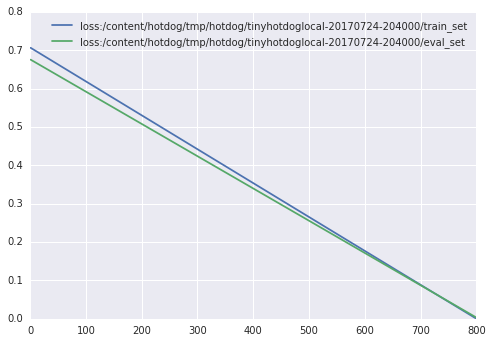

In [110]:
summary.plot('loss')

In [260]:
tb_id = TensorBoard.start(model_dir)

TensorBoard was started successfully with pid 4833. Click here to access it.

# Sanity Check
Flower was NOT part of the training set

Predicting...


no_hotdog(0.98038)

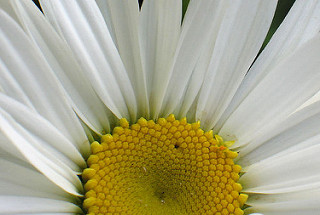

In [111]:
images = ['gs://cloud-ml-data/img/flower_photos/daisy/15207766_fc2f1d692c_n.jpg']
df = model.predict(model_dir, images, show_image=True)

# Time to Batch Predict

In [127]:
!wget https://thumbs.dreamstime.com/z/hot-dog-grilling-24681095.jpg

converted 'https://thumbs.dreamstime.com/z/hot-dog-grilling-24681095.jpg' (ANSI_X3.4-1968) -> 'https://thumbs.dreamstime.com/z/hot-dog-grilling-24681095.jpg' (UTF-8)
--2017-07-24 20:54:27--  https://thumbs.dreamstime.com/z/hot-dog-grilling-24681095.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.163.122
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.163.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169004 (165K) [image/jpeg]
Saving to: 'hot-dog-grilling-24681095.jpg'

hot-dog-grilling-24 100%[=====================>] 165.04K  --.-KB/s   in 0.03s  

2017-07-24 20:54:27 (4.88 MB/s) - 'hot-dog-grilling-24681095.jpg' saved [169004/169004]



In [128]:
#images = ['/content/hotdog/notdogfull.jpg','/content/hotdog/landscape-1464119445-buffalo-chicken-taquitos-004.jpg','/content/hotdog/landscape-1464119445-buffalo-chicken-taquitos-004.jpg', '/content/hotdog/2016-09-20_1101.jpg', '/content/hotdog/cf468fb8e2efb4fbbc4f2895f71f1e32.jpg', '/content/hotdog/Cartoon-hot-dog-clipart-kid-2.jpeg']
images = ['/content/hotdog/hot-dog-grilling-24681095.jpg']

Predicting...


no_hotdog(0.51529)

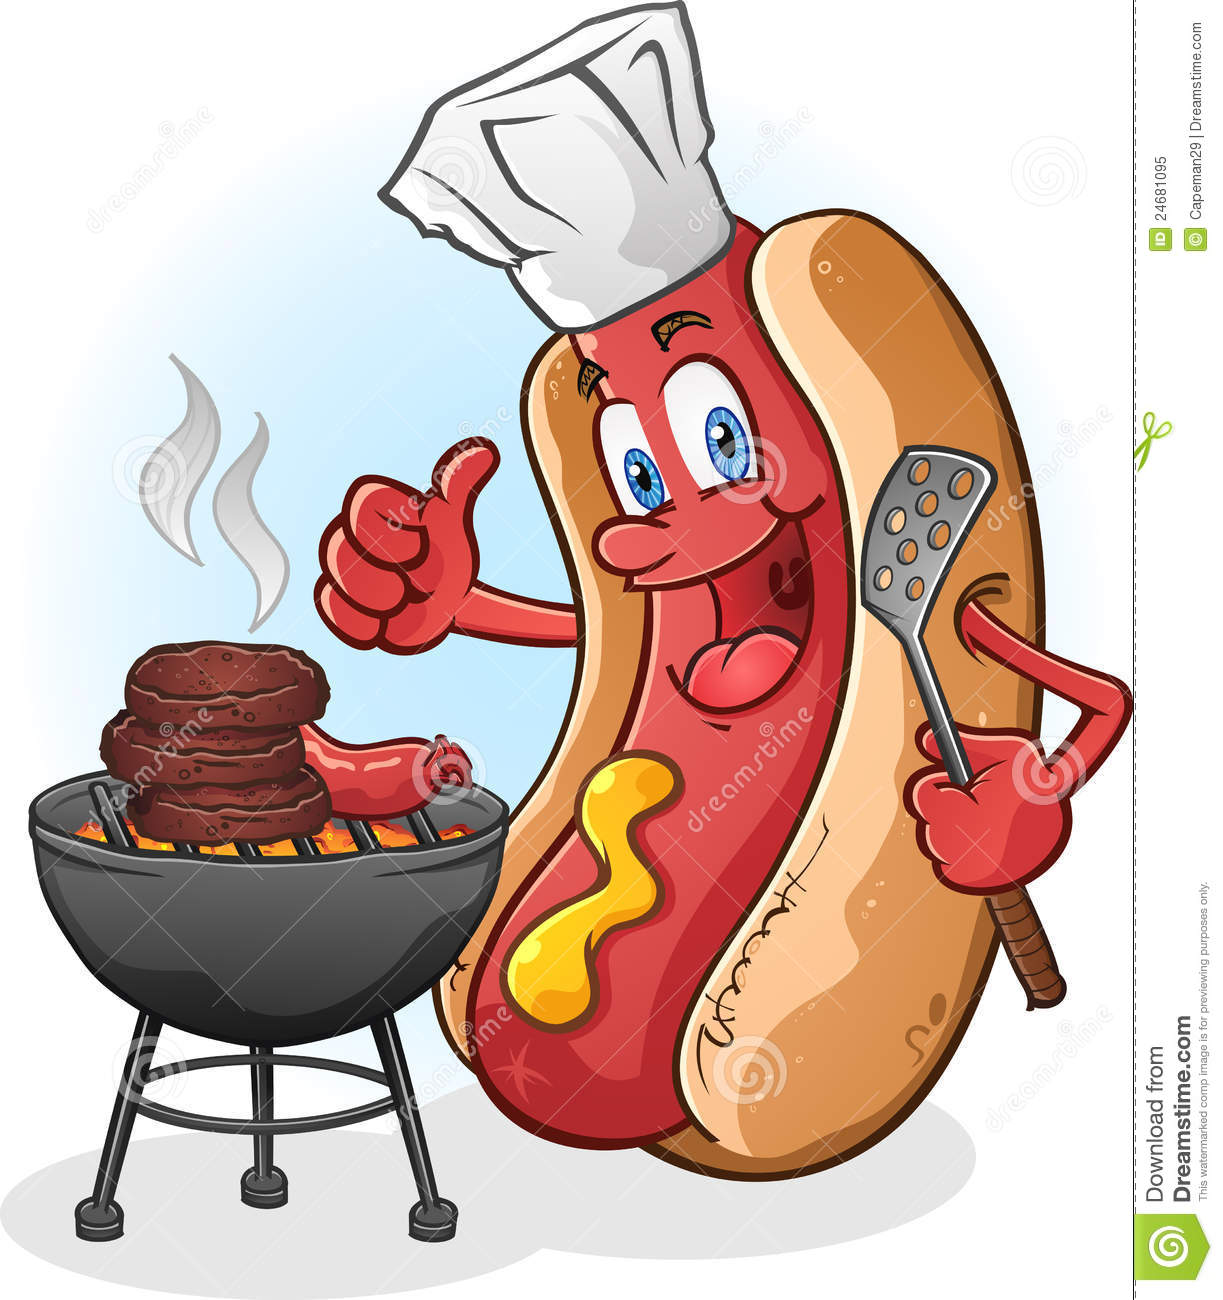

In [129]:
df = model.predict(model_dir, images, show_image=True)